<a href="https://colab.research.google.com/github/Glenap/AI-Odyssey-Deep-Dive-Into-Transformers-and-its-Applications/blob/main/231154_VikashYadav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt



In [6]:
with open('names.txt', 'r') as file:
    names = file.read().strip().split('\n')


chars = sorted(list(set(''.join(names))))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}


eol_token = '\n'
chars.append(eol_token)
char_to_idx[eol_token] = len(chars) - 1
idx_to_char[len(chars) - 1] = eol_token

In [7]:

def one_hot_encode(sequence, n_chars):
    encoding = np.zeros((len(sequence), n_chars), dtype=np.float32)
    for i, char in enumerate(sequence):
        encoding[i, char_to_idx[char]] = 1.0
    return encoding


In [8]:
def decode_sequence(sequence):
    return ''.join([idx_to_char[idx] for idx in sequence])


class NamesDataset(Dataset):
    def __init__(self, names, char_to_idx, eol_token='\n'):
        self.names = names
        self.char_to_idx = char_to_idx
        self.eol_token = eol_token

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        input_seq = name
        target_seq = name[1:] + self.eol_token
        input_seq_encoded = [self.char_to_idx[char] for char in input_seq]
        target_seq_encoded = [self.char_to_idx[char] for char in target_seq]
        return torch.tensor(input_seq_encoded), torch.tensor(target_seq_encoded)

In [9]:
dataset = NamesDataset(names, char_to_idx)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [10]:

class NameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NameRNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_chars = len(chars)
hidden_size = 128
model = NameRNN(n_chars, hidden_size, n_chars)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
losses = []
accuracies = []

n_epochs = 10

for epoch in range(n_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for input_seq, target_seq in dataloader:
        hidden = model.init_hidden()
        model.zero_grad()
        loss = 0

        for i in range(input_seq.size(1)):
            input_char = F.one_hot(input_seq[:, i], num_classes=n_chars).float()
            target_char = target_seq[:, i]
            output, hidden = model(input_char, hidden)
            loss += criterion(output, target_char)

            _, predicted = torch.max(output, 1)
            total += target_char.size(0)
            correct += (predicted == target_char).sum().item()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch 1/10, Loss: 25.4280, Accuracy: 31.10%
Epoch 2/10, Loss: 23.1594, Accuracy: 35.30%
Epoch 3/10, Loss: 22.7514, Accuracy: 35.97%
Epoch 4/10, Loss: 22.5766, Accuracy: 36.10%
Epoch 5/10, Loss: 22.4778, Accuracy: 36.25%
Epoch 6/10, Loss: 22.4177, Accuracy: 36.25%
Epoch 7/10, Loss: 22.3603, Accuracy: 36.42%
Epoch 8/10, Loss: 22.3452, Accuracy: 36.30%
Epoch 9/10, Loss: 22.3325, Accuracy: 36.44%
Epoch 10/10, Loss: 22.3180, Accuracy: 36.45%


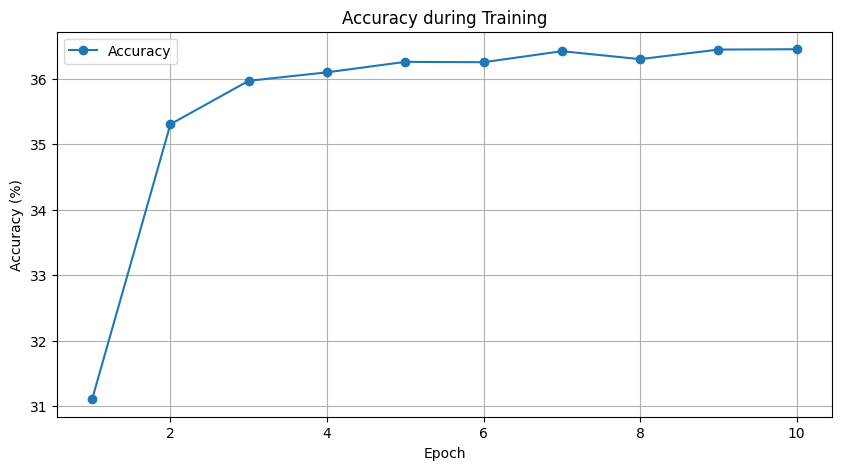

In [12]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), accuracies, marker='o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during Training')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def generate_name(start_char='A', max_length=20):
    with torch.no_grad():
        input_char = F.one_hot(torch.tensor([char_to_idx[start_char]]), num_classes=n_chars).float()
        hidden = model.init_hidden()
        name = start_char

        for _ in range(max_length):
            output, hidden = model(input_char, hidden)
            topv, topi = output.topk(1)
            char_idx = topi[0][0].item()
            char = idx_to_char[char_idx]
            if char == eol_token:
                break
            name += char
            input_char = F.one_hot(torch.tensor([char_idx]), num_classes=n_chars).float()

        return name

for _ in range(10):
    print(generate_name(start_char=np.random.choice(chars[:-1])))

chand
j3i8
x0a7
2389,kalfsha
5379,shagsh
f0a7
j3i8
2389,kalfsha
e1
b3i8
